In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.layers import Dropout, SpatialDropout2D
import numpy as np
from PIL import Image
import argparse
import math
import pandas as pd
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras

C:\Users\amlanpraharaj\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def display(img):
    # (784) => (28,28)
    one_image = img.reshape(28,28)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()

def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    #model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('tanh'))
    #model.add(SpatialDropout2D(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    #model.add(SpatialDropout2D(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model



def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

C:\Users\amlanpraharaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  # This is added back by InteractiveShellApp.init_path()


ep 0 d_loss : 0.363217
ep 0 g_loss : 1.532636


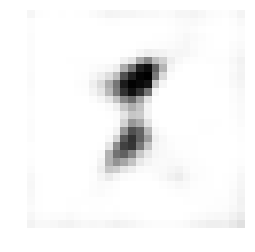

ep 10 d_loss : 0.320631
ep 10 g_loss : 1.669258


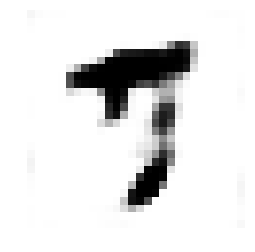

ep 20 d_loss : 0.198681
ep 20 g_loss : 2.119959


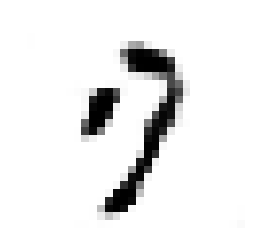

ep 30 d_loss : 0.386427
ep 30 g_loss : 1.799525


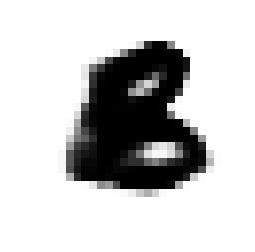

ep 40 d_loss : 0.391256
ep 40 g_loss : 1.316686


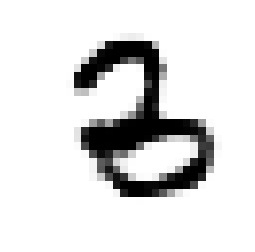

ep 50 d_loss : 0.364608
ep 50 g_loss : 1.482804


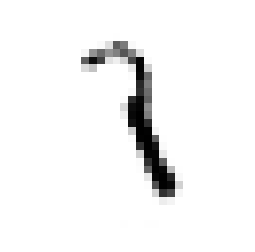

ep 60 d_loss : 0.341767
ep 60 g_loss : 1.979761


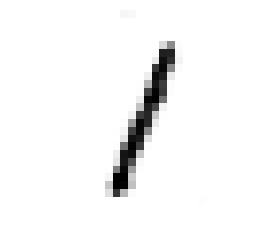

ep 70 d_loss : 0.287065
ep 70 g_loss : 1.857727


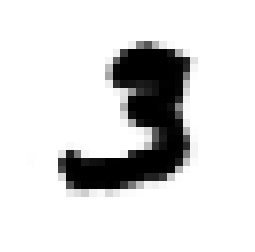

ep 80 d_loss : 0.266763
ep 80 g_loss : 2.052946


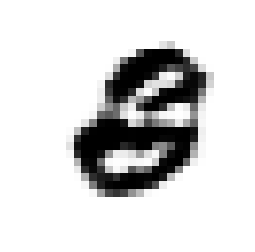

ep 90 d_loss : 0.289733
ep 90 g_loss : 2.192810


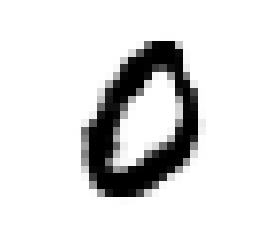

In [3]:
BATCH_SIZE = 256

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, :, :, None]
X_test = X_test[:, :, :, None]
d = discriminator_model()
g = generator_model()
d_on_g = generator_containing_discriminator(g, d)
d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)

g.compile(loss='binary_crossentropy', optimizer="SGD")
d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)

d.trainable = True
d.compile(loss='binary_crossentropy', optimizer=d_optim)

for epoch in range(100):
    for index in range(int(X_train.shape[0]/BATCH_SIZE)):
        noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = g.predict(noise, verbose=0)            
        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        d_loss = d.train_on_batch(X, y)
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        d.trainable = False
        g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
        d.trainable = True
        if index % 10 == 9:
            g.save_weights('generator', True)
            d.save_weights('discriminator', True)
    if(epoch%10 == 0):
        print("ep %d d_loss : %f" % (epoch, d_loss))
        print("ep %d g_loss : %f" % (epoch, g_loss))
        display(generated_images[-1,:,:,:])

In [4]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

def generate(BATCH_SIZE, nice=False):
    g = generator_model()
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    g.load_weights('generator')
    if nice:
        d = discriminator_model()
        d.compile(loss='binary_crossentropy', optimizer="SGD")
        d.load_weights('discriminator')
        noise = np.random.uniform(-1, 1, (BATCH_SIZE*20, 100))
        generated_images = g.predict(noise, verbose=1)
        d_pret = d.predict(generated_images, verbose=1)
        index = np.arange(0, BATCH_SIZE*20)
        index.resize((BATCH_SIZE*20, 1))
        pre_with_index = list(np.append(d_pret, index, axis=1))
        pre_with_index.sort(key=lambda x: x[0], reverse=True)
        nice_images = np.zeros((BATCH_SIZE,) + generated_images.shape[1:3], dtype=np.float32)
        nice_images = nice_images[:, :, :, None]
        for i in range(BATCH_SIZE):
            idx = int(pre_with_index[i][1])
            nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]
        image = combine_images(nice_images)
    else:
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        generated_images = g.predict(noise, verbose=1)
        image = combine_images(generated_images)
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(
        "generated_image_new.png")

In [5]:
generate(BATCH_SIZE=256, nice=True)

C:\Users\amlanpraharaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  # This is added back by InteractiveShellApp.init_path()


5120/5120 [==============================] - 0s 95us/step
